In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

2024-07-11 09:57:57.469605: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-11 09:57:57.469627: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-11 09:57:57.469631: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-11 09:57:57.469678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-11 09:57:57.469710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            print(category)
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            print("ADD CLASS", source_name, class_id, class_name)
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [4]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('data2/train/instances_default.json', 'data2/train')
dataset_train.prepare()

#In this example, I do not have annotations for my validation data, so I am loading train data
dataset_val = CocoLikeDataset()
dataset_val.load_data('data2/train/instances_default.json', 'data2/train')
dataset_val.prepare()

{'id': 1, 'name': 'Kiste', 'supercategory': ''}
ADD CLASS coco_like 1 Kiste
{'id': 2, 'name': 'Packung', 'supercategory': ''}
ADD CLASS coco_like 2 Packung
{'id': 3, 'name': 'Packung (oben)', 'supercategory': ''}
ADD CLASS coco_like 3 Packung (oben)
{'id': 1, 'name': 'Kiste', 'supercategory': ''}
ADD CLASS coco_like 1 Kiste
{'id': 2, 'name': 'Packung', 'supercategory': ''}
ADD CLASS coco_like 2 Packung
{'id': 3, 'name': 'Packung (oben)', 'supercategory': ''}
ADD CLASS coco_like 3 Packung (oben)


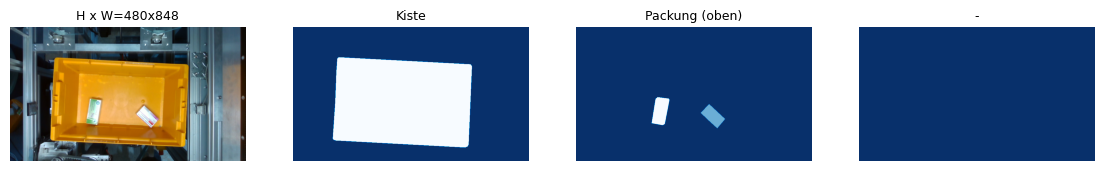

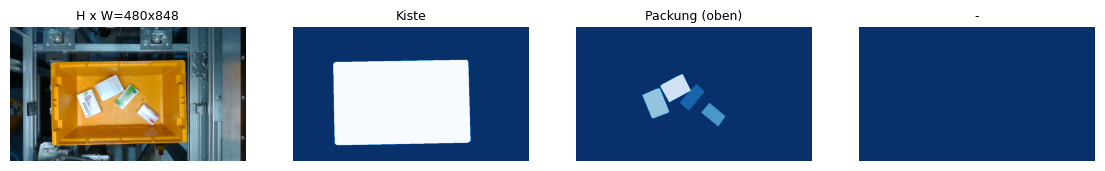

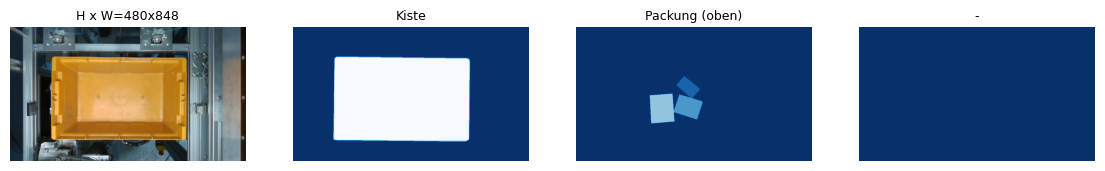

In [5]:
dataset = dataset_train
image_ids = dataset.image_ids
#image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    try:
        image = dataset.load_image(image_id)
    except:
        continue
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names, limit=3)  #limit to total number of classes

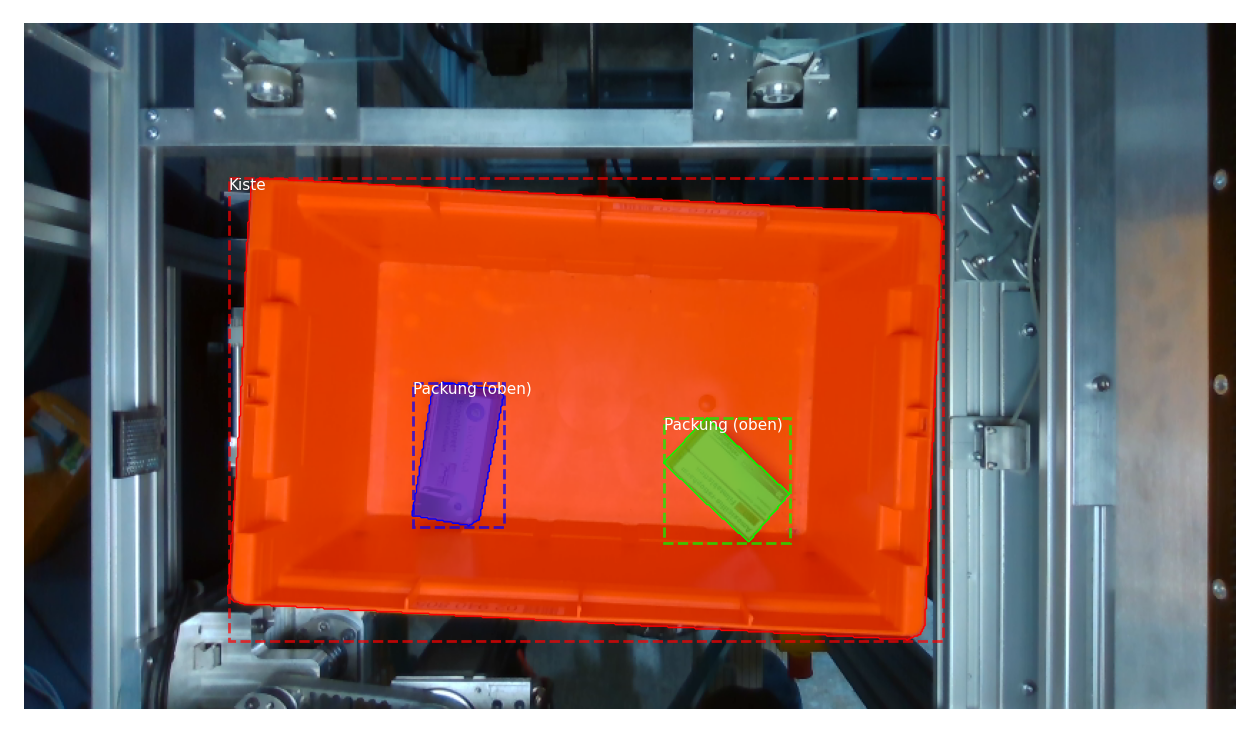

In [6]:
# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [7]:
# define a configuration for the model
class CustomConfig(Config):
	# define the name of the configuration
	NAME = "custom_cfg_coco"
	# number of classes (background + Kiste + Packung + Packung (oben))
	NUM_CLASSES = 1 + 3
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
	BACKBONE = "resnet50"
# prepare config
config = CustomConfig()
config.display() 


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [8]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "coco_weights/mask_rcnn_coco.h5")

########################
#Weights are saved to root D: directory. need to investigate how they can be
#saved to the directory defined... "logs_models"

###############

In [11]:
# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/logs/custom_cfg_coco20240711T0959/mask_rcnn_custom_cfg_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc     

/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-07-11 09:59:11.575202: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_class_logits_1/bias/Assign' id:12156 op device:{requested: '', assigned: ''} def:{{{node mrcnn_class_logits_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](mrcnn_class_logits_1/bias, mrcnn_class_logits_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


InvalidArgumentError: Graph execution error:

Detected at node 'mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter' defined at (most recent call last):
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/runpy.py", line 86, in _run_code
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/var/folders/1k/lyyvyrld0x186lb492fcl7yr0000gn/T/ipykernel_33038/1906244250.py", line 2, in <module>
    File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 1844, in __init__
    File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 2011, in build
    File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 976, in fpn_classifier_graph
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 814, in __call__
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 2182, in _maybe_build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/rnn/time_distributed.py", line 137, in build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/rnn/base_wrapper.py", line 57, in build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 154, in build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 459, in add_weight
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_utils.py", line 137, in make_variable
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/initializers/initializers.py", line 647, in __call__
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/initializers/initializers.py", line 672, in _generate_init_val
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/backend.py", line 2102, in random_uniform
Node: 'mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter'
Detected at node 'mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter' defined at (most recent call last):
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/runpy.py", line 86, in _run_code
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/events.py", line 80, in _run
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/var/folders/1k/lyyvyrld0x186lb492fcl7yr0000gn/T/ipykernel_33038/1906244250.py", line 2, in <module>
    File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 1844, in __init__
    File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 2011, in build
    File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 976, in fpn_classifier_graph
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 814, in __call__
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 2182, in _maybe_build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/rnn/time_distributed.py", line 137, in build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/rnn/base_wrapper.py", line 57, in build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 154, in build
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 459, in add_weight
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_utils.py", line 137, in make_variable
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/initializers/initializers.py", line 647, in __call__
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/initializers/initializers.py", line 672, in _generate_init_val
    File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/backend.py", line 2102, in random_uniform
Node: 'mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter'
Cannot assign a device for operation mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter: Could not satisfy explicit device specification '' because the node {{colocation_node mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='' supported_device_types_=[CPU] possible_devices_=[]
VarHandleOp: GPU CPU 
Mul: GPU CPU 
AddV2: GPU CPU 
Sub: GPU CPU 
AssignVariableOp: GPU CPU 
StatelessRandomGetKeyCounter: CPU 
StatelessRandomUniformV2: GPU CPU 
Const: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/shape (Const) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/min (Const) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/max (Const) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter/seed (Const) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter (StatelessRandomGetKeyCounter) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomUniformV2/alg (Const) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomUniformV2 (StatelessRandomUniformV2) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/sub (Sub) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/mul (Mul) 
  mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform (AddV2) 
  mrcnn_class_logits_1/kernel (VarHandleOp)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  mrcnn_class_logits_1/kernel/Assign (AssignVariableOp) 

	 [[{{node mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter}}]]

Original stack trace for 'mrcnn_class_logits_1/kernel/Initializer/stateless_random_uniform/StatelessRandomGetKeyCounter':
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/runpy.py", line 86, in _run_code
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/asyncio/events.py", line 80, in _run
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/1k/lyyvyrld0x186lb492fcl7yr0000gn/T/ipykernel_33038/1906244250.py", line 2, in <module>
  File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 1844, in __init__
  File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 2011, in build
  File "/Users/basti/Documents/maqum/Mask-RCNN_TF2.14.0/mrcnn/model.py", line 976, in fpn_classifier_graph
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 814, in __call__
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 2182, in _maybe_build
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/rnn/time_distributed.py", line 137, in build
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/rnn/base_wrapper.py", line 57, in build
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 154, in build
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_v1.py", line 459, in add_weight
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 492, in _add_variable_with_custom_getter
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/base_layer_utils.py", line 137, in make_variable
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/variables.py", line 195, in __call__
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/variable_v1.py", line 306, in _variable_call
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/variable_v1.py", line 299, in <lambda>
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/ref_variable.py", line 65, in default_variable_creator
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/variables.py", line 198, in __call__
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1809, in __init__
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1993, in _init_from_args
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/initializers/initializers.py", line 647, in __call__
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/initializers/initializers.py", line 672, in _generate_init_val
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/backend.py", line 2102, in random_uniform
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/stateless_random_ops.py", line 402, in stateless_random_uniform
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/random_ops_util.py", line 149, in get_key_counter_alg
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/random_ops_util.py", line 112, in _get_key_counter
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/ops/gen_stateless_random_ops_v2.py", line 195, in stateless_random_get_key_counter
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 2657, in _create_op_internal
  File "/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1161, in from_node_def


### Validate

In [10]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

In [11]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "custom_cfg_coco"
	# number of classes (background + Blue Marbles + Non Blue marbles)
	NUM_CLASSES = 1 + 3
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [14]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-07-10 14:41:34.530313: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_detection_6/Reshape_1' id:59977 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection_6/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection_6/packed, mrcnn_detection_6/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-07-10 14:41:35.046130: W tensorflow/c/c_api.cc:305] Operation '{name:'bn4a_branch2c_5/beta/Assign' id:47148 op device:{requested: '', ass

Train mAP: 0.000


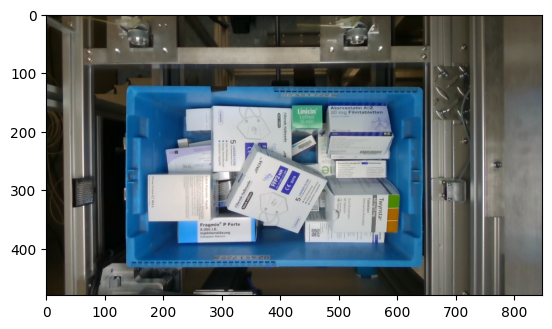

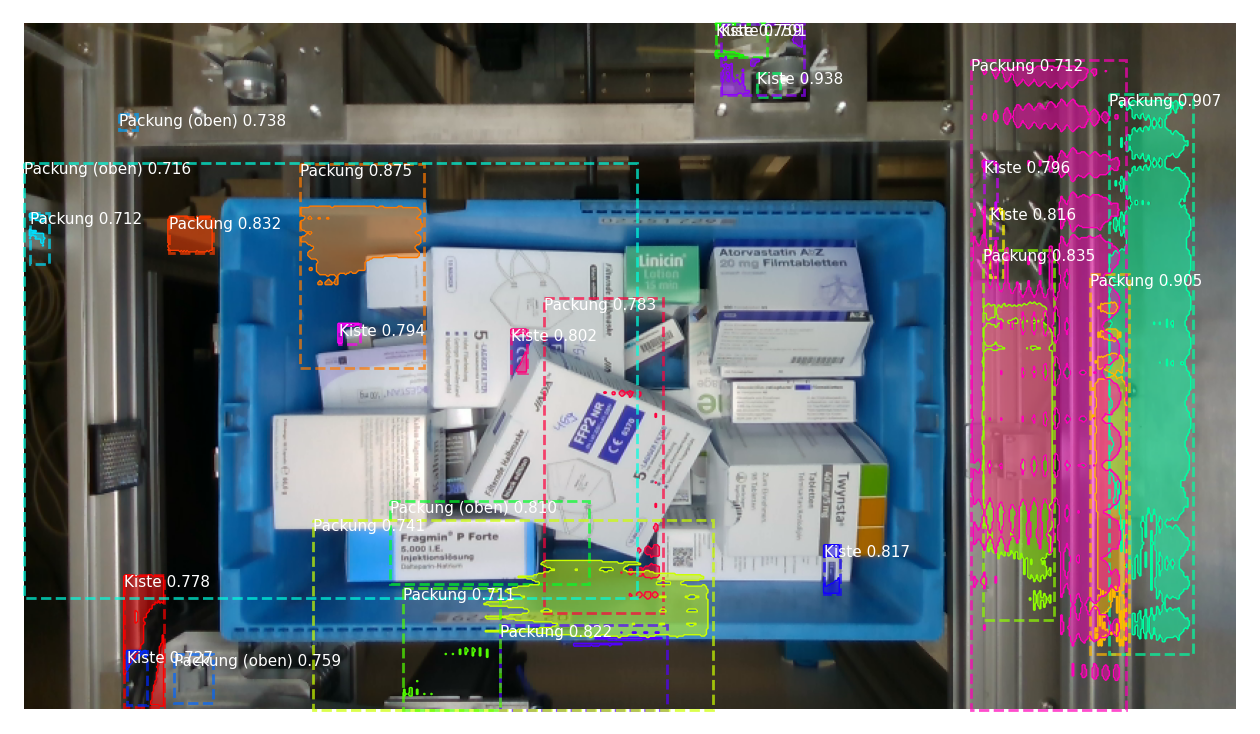

In [19]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model.load_weights('coco_weights/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# evaluate model on training dataset
train_mAP = evaluate_model(dataset_train, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
# test_mAP = evaluate_model(dataset_train, model, cfg)
# print("Test mAP: %.3f" % test_mAP)

#################################################
#Test on a single image
img = skimage.io.imread("data/train/3228664_Box__240425_040600_color.png")
plt.imshow(img)

detected = model.detect([img])
results = detected[0]
class_names = ['BG', 'Kiste', 'Packung', 'Packung (oben)']
display_instances(img, results['rois'], results['masks'], 
                  results['class_ids'], class_names, results['scores'])

In [23]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model.load_weights('logs/custom_cfg_coco20240710T0942/mask_rcnn_custom_cfg_coco_0010.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, cfg,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, cfg), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

Re-starting from epoch 10


/Users/basti/.pyenv/versions/miniforge3-23.11.0-0/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-07-10 14:50:08.502444: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_detection_7/Reshape_1' id:70733 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection_7/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection_7/packed, mrcnn_detection_7/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-07-10 14:50:08.962637: W tensorflow/c/c_api.cc:305] Operation '{name:'bn4p_branch2c_7/gamma/Assign' id:67647 op device:{requested: '', as

mAP:  0.0
